In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 457 (delta 115), reused 98 (delta 82), pack-reused 250
Receiving objects: 100% (457/457), 73.76 MiB | 20.18 MiB/s, done.
Resolving deltas: 100% (209/209), done.
Checking out files: 100% (68/68), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=30522 sha256=2d07a689e18c635e5b73173f16190b907446fba2604ccb2b22a39895d778f3ab
  Stored in directory: /tmp/pip-ephem-wheel-cac

In [2]:
from dul_2021.utils.hw4_utils import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.optim import Adam
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta
from torch.distributions import Bernoulli
from torch.autograd.functional import vjp, jvp

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
!pip install torchdiffeq
from torchdiffeq import odeint_adjoint
import torchdiffeq

# Bonus 3: CNF

Implement CNF with Hutchinson trace estimator and bottleneck trick

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [6]:
class MLP(nn.Module):
  def __init__(self, bottleneck_dim, hid_dim, z_dim):
    super().__init__()
    self.lin1 = nn.Sequential(nn.Linear(z_dim, hid_dim),
                              nn.Tanh(),
                              nn.Linear(hid_dim, bottleneck_dim),
                              nn.Tanh())
    
    self.lin2 = nn.Sequential(nn.Linear(bottleneck_dim, hid_dim),
                              nn.Tanh(),
                              nn.Linear(hid_dim, z_dim),
                              nn.Tanh())
    
    
    bern = Bernoulli(probs=torch.full((128, bottleneck_dim), 0.5))
    self.K = 100
    self.epsilon = torch.stack([bern.sample() for _ in range(self.K)]) * 2 - 1
    self.epsilon = self.epsilon.to(device)
    
  def forward(self, t, z_aug):
    z_t = z_aug[:, :-1]

    # Hutchinson trace estimator + Bottleneck
    samples = torch.empty((self.K, 128), device=device)
    
    for i, eps in enumerate(self.epsilon):
      h = vjp(self.lin1, z_t, eps, create_graph=True)
      z = jvp(self.lin2, h[0], eps, create_graph=True)
      
      samples[i] = (h[1] * z[1]).sum(dim=1)

    tr_estimator = - samples.mean(dim=0).unsqueeze(1)
    
    return torch.cat((z[0], tr_estimator), dim=1)

In [7]:
def get_loss(z):
  mse = 0.5 * (z[:, :-1] ** 2).sum(dim=1).mean()
  offset = z[:, -1].mean()
  return offset + mse

In [14]:
def b3(train_data, test_data):
  """
  train_data: An (n_train, 10) numpy array of floats in R^10
  test_data: An (n_test, 10) numpy array of floats in R^10

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  """
  
  model = MLP(5, 64, 10).to(device)
  opt = Adam(model.parameters(), 1e-4)

  loss_train_record = []
  loss_test_record =[]
  batch_size = 128

  # Evaluation on initialization
  N = test_data.shape[0]
  p = np.random.permutation(N)
  total_loss = []
  for i in range(0, N, batch_size):
    idx = p[i: i + batch_size]
    if len(idx) < batch_size:
      continue
      
    x_aug = torch.cat((torch.tensor(train_data[idx]), torch.zeros((batch_size, 1))),dim=1).float()
    x_aug = x_aug.to(device)

    z_aug = odeint_adjoint(model, x_aug,
                           torch.FloatTensor([0, 10]),
                           atol=1e-5, rtol=1e-5,
                           method='dopri5')[1]
    
    loss = get_loss(z_aug.detach())
    total_loss.append(loss.item() / test_data[idx].shape[1] + .5 * np.log(2 * np.pi))

  loss_test_record.append(sum(total_loss) / len(total_loss))
  
  for epoch in range(5):
    
    # Training 
    N = train_data.shape[0]
    p = np.random.permutation(N)
    for i in range(0, N, batch_size):
      idx = p[i: i + batch_size]
      if len(idx) < batch_size:
        continue
      
      x_aug = torch.cat((torch.tensor(train_data[idx]), torch.zeros((batch_size, 1))),dim=1).float()
      x_aug = x_aug.to(device)

      z_aug = odeint_adjoint(model, x_aug,
                             torch.FloatTensor([0, 10]),
                             atol=1e-5, rtol=1e-5,
                             method='dopri5')[1]
    
      loss = get_loss(z_aug)

      opt.zero_grad()
      loss.backward()
      opt.step()
    
      loss_train_record.append(loss.item() / train_data[idx].shape[1] + .5 * np.log(2 * np.pi))

    # Evaluation on test set
    N = test_data.shape[0]
    p = np.random.permutation(N)
    total_loss = []
    for i in range(0, N, batch_size):
      idx = p[i: i + batch_size]
      if len(idx) < batch_size:
        continue
      
      x_aug = torch.cat((torch.tensor(train_data[idx]), torch.zeros((batch_size, 1))),dim=1).float()
      x_aug = x_aug.to(device)

      z_aug = odeint_adjoint(model, x_aug,
                             torch.FloatTensor([0, 10]),
                             atol=1e-5, rtol=1e-5,
                             method='dopri5')[1]

      loss = get_loss(z_aug.detach())
      total_loss.append(loss.item() / test_data[idx].shape[1] + .5 * np.log(2 * np.pi))

    loss_test_record.append(sum(total_loss) / len(total_loss))

    print(f"EPOCH : {epoch + 1}")
    print(f"\t loss train : {sum(loss_train_record[-10:]) / 10:.5f}")
    print(f"\t loss test : {loss_test_record[-1]:.5f}")

  return loss_train_record, loss_test_record

### Results

Once you've implemented `b3`, execute the cells below to visualize and save your results



/usr/local/lib/python3.7/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


EPOCH : 1
	 loss train : 1.96787
	 loss test : 2.00832
EPOCH : 2
	 loss train : 1.61605
	 loss test : 1.69380
EPOCH : 3
	 loss train : 1.50806
	 loss test : 1.56059
EPOCH : 4
	 loss train : 1.44197
	 loss test : 1.50596
EPOCH : 5
	 loss train : 1.40525
	 loss test : 1.47173
Final Test Loss: 1.4717


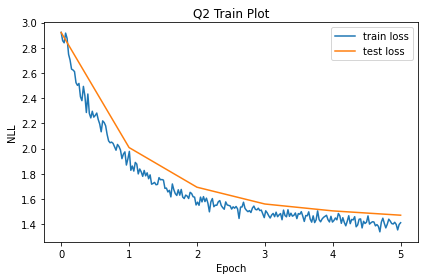

In [15]:
q2_save_results(b3)